### An example of how to manipulate the dateframes

In [1]:
import sys,os,os.path

# tell python to look for the path to analyse
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import pandas as pd
import h5py

from core import processing as proc
from core import plotting as pl
from core import misc as misc
from core import fitting as fit

Currently you have:
- pmtrw: the raw pmt waveforms
- subwf: the pmt waveforms with baseline subtraction
- summary: the pandas dataframe containing:
    -    integration values (ADC)
    -    sigma values across the waveform peak
    -    height of the waveform peak

#### To access each separate section, do so as described below:

Read in the data

In [3]:
path = "../../storage/John/testing/RUN000072/PMT/Nominal/wave_6.h5"
#df = pd.read_hdf(path, key = 'pmtrw')
f = h5py.File(path)
print(list(f.keys()))


['pmtrw', 'subwf', 'summary']


### ACCESSING WAVEFORMS

Simply collect them element-wise as described below

Waveform values:
[8192 8196 8189 8196 8193 8192 8189 8200 8195 8190 8202 8187 8195 8192
 8198 8196 8189 8195 8196 8193 8193 8195 8188 8195 8189 8196 8192 8197
 8196 8190 8195 8188 8196 8195 8196 8193 8198 8187 8192 8196 8193 8195
 8191 8195 8193 8195 8189 8196 8190 8198 8192 8187 8200 8187 8200 8193
 8198 8189 8195 8188 8196 8194 8194 8192 8195 8197 8190 8193 8196 8193
 8197 8195 8192 8194 8196 8190 8195 8194 8196 8193 8194 8193 8195 8194
 8192 8196 8189 8196 8193 8191 8196 8193 8198 8194 8194 8193 8191 8187
 8195 8191 8185 8193 8195 8188 8194 8192 8191 8199 8191 8195 8195 8194
 8194 8196 8196 8195 8185 8202 8194 8195 8193 8190 8199 8192 8194 8196
 8198 8191 8195 8195]


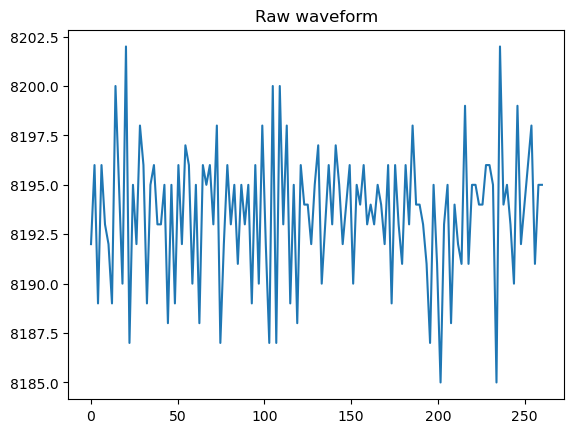

In [4]:
# take first waveform
wf_1 = f['pmtrw'][0]
print("Waveform values:")
print(wf_1)

# visualising it
length = len(wf_1)

time = np.linspace(0,length*2, num = length)
plt.plot(time, wf_1)
plt.title("Raw waveform")
plt.show()

Same rules apply for the subtracted waveforms

Waveform values:
[ 2. -2.  5. -2.  1.  2.  5. -6. -1.  4. -8.  7. -1.  2. -4. -2.  5. -1.
 -2.  1.  1. -1.  6. -1.  5. -2.  2. -3. -2.  4. -1.  6. -2. -1. -2.  1.
 -4.  7.  2. -2.  1. -1.  3. -1.  1. -1.  5. -2.  4. -4.  2.  7. -6.  7.
 -6.  1. -4.  5. -1.  6. -2.  0.  0.  2. -1. -3.  4.  1. -2.  1. -3. -1.
  2.  0. -2.  4. -1.  0. -2.  1.  0.  1. -1.  0.  2. -2.  5. -2.  1.  3.
 -2.  1. -4.  0.  0.  1.  3.  7. -1.  3.  9.  1. -1.  6.  0.  2.  3. -5.
  3. -1. -1.  0.  0. -2. -2. -1.  9. -8.  0. -1.  1.  4. -5.  2.  0. -2.
 -4.  3. -1. -1.]


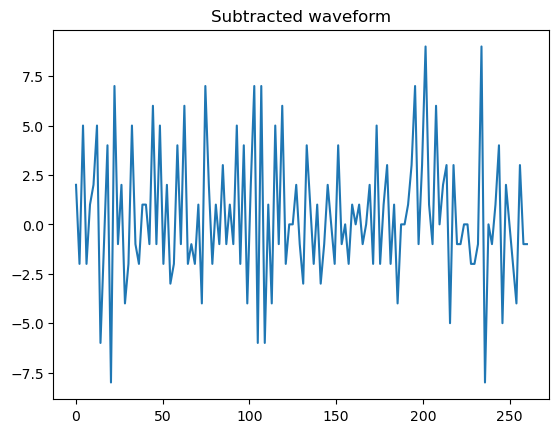

In [5]:
# take first waveform
wf_1 = f['subwf'][0]
print("Waveform values:")
print(wf_1)

# visualising it
length = len(wf_1)

time = np.linspace(0,length*2, num = length)
plt.plot(time, wf_1)
plt.title("Subtracted waveform")
plt.show()

### ACCESSING THE SUMMARY TABLE

This requires using the function `read_hdf` to interpret the information from the summary table. This only works because I spend hours trying to find a nice way to format it within the h5 file and gave up.

,ADC,sigma,heights
0,25.0,NaN,9.0
1,-7.0,NaN,8.0
2,23.0,9.701792,8.0
3,4.0,NaN,10.0
4,-10.0,14.600000,8.0
...,...,...,...
563071,6.0,NaN,7.0
563072,-2.0,NaN,198.0
563073,-13.0,NaN,10.0
563074,-12.0,10.739336,8.0


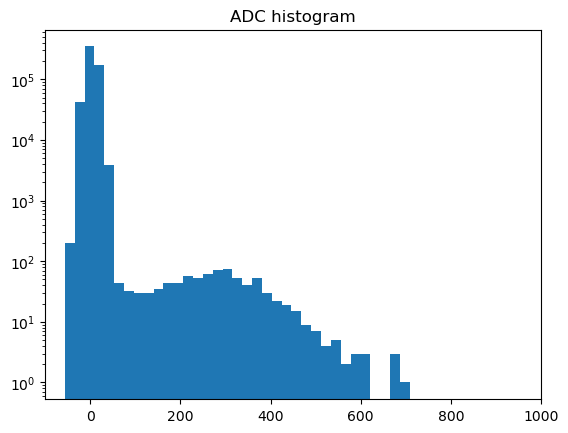

In [6]:
df = pd.read_hdf(path)
display(df)

plt.hist(df.ADC.to_numpy(), bins = 100)
plt.yscale('log')
plt.xlim([-100,1000])
plt.title("ADC histogram")
plt.show()

This now allows for basic data manipulation, as shown:

In [8]:
df['sigma'] = df['sigma'].fillna(0)

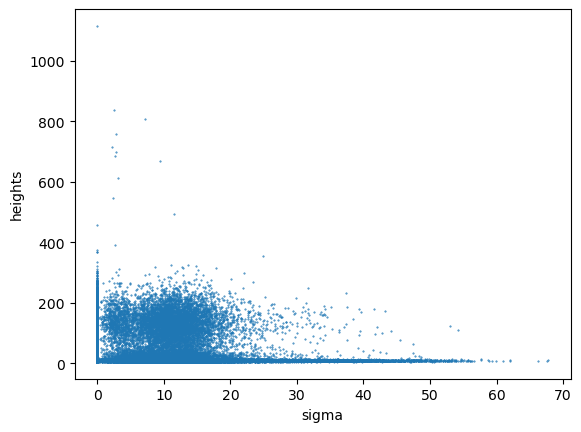

In [11]:
plt.scatter(df['sigma'], df['heights'], s = 0.2)
plt.xlabel('sigma')
plt.ylabel('heights')
plt.show()

In [13]:
# apply mask to the dataframe to collect sigma = 0 events with highest height first 
df_zeros = df[df['sigma'] == 0]
display(df_zeros.sort_values('heights'))

,ADC,sigma,heights
78887,-2.0,0.0,4.0
190425,-15.0,0.0,4.0
3468,1.0,0.0,4.0
284725,-3.0,0.0,4.0
230859,-6.0,0.0,4.0
...,...,...,...
404330,3.0,0.0,366.0
412311,-1.0,0.0,369.0
36782,3.0,0.0,374.0
263387,-6.0,0.0,458.0


In [14]:
def print_wf(number = 1):
    
    wf_1 = f['subwf'][number]
    print("Waveform values:")
    print(wf_1)

    # visualising it
    length = len(wf_1)

    time = np.linspace(0,length*2, num = length)
    plt.plot(time, wf_1)
    plt.title("Event {}".format(number))
    plt.show()